# Goes through all simulations and print statistics

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mtplc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import tomli
import tqdm
import pickle, gzip


from qutip import Qobj
import qutip as qt

from pathlib import Path

ROOT = Path('simulations')


OBSERVABLES = [
    "energy"
]
VARIABLE_COLUMNS = [
    "phaseonium_phi_hot",
    "phaseonium_phi_cold",
    "cavity1_expanding_force",
    "cavity1_compressing_force",
    "cavity2_expanding_force",
    "cavity2_compressing_force",
    "stroke_time_isochore",
]
OMEGA = 5.0
T_HOT = 2.5
T_COLD = 1.0

REGENERATE = False

# Colors for the strokes
CS1 = "#454545"
CS2 = "#888888"

ledger = pd.read_csv(ROOT / 'simulations_ledger.csv', header=0)
ledger["Error"] = [0 for _ in range(len(ledger))]
ledger.set_index("meta_name", inplace=True)
print(f"There are {len(ledger)} simulations in the ledger")

There are 128 simulations in the ledger


In [2]:
def assign_forces(config, strokes, sampling_times):
    f1_exp = config["cavity1"]["expanding_force"]
    f1_comp = config["cavity1"]["compressing_force"]
    f2_exp = config["cavity2"]["expanding_force"]
    f2_comp = config["cavity2"]["compressing_force"]
    forces1 = []
    forces2 = []
    for t in sampling_times:
        if t < strokes[0][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[1][1]:
            forces1.append(f1_exp)
            forces2.append(f2_exp)
        elif t < strokes[2][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[3][1]:
            forces1.append(f1_comp)
            forces2.append(f2_comp)
        else:
            forces1.append(0)
            forces2.append(0)

    return np.array(forces1), np.array(forces2)


def read_configuration(filepath, system_evolution_times):

    with open(filepath / "config.toml", "rb") as config_file:
            config = tomli.load(config_file)

    ndims = int(config["meta"]["dims"])
    dt = config["meta"]["dt"]
    alpha = config["cavity1"]["alpha"]
    surfaces = (config["cavity1"]["surface"], config["cavity2"]["surface"])

    isochore_steps = config["stroke_time"]["isochore"]
    isochore_samplings = config["samplings"]["isochore"]
    adiabatic_samplings = config["samplings"]["adiabatic"]

    cycle_steps = np.load(filepath / "cycle_steps.npy")  # Duration of each step
    strokes = [
        (0, cycle_steps[0]),
        (cycle_steps[0] + dt, cycle_steps[1]),
        (cycle_steps[1] + dt, cycle_steps[2]),
        (cycle_steps[2] + dt, cycle_steps[3]),
    ]
    
    samplings = sorted(system_evolution_times, key=lambda x: int(x))

    # Take the left-hand side of each interval
    sampling_times = np.array([
        *np.linspace(*strokes[0], isochore_samplings),
        *np.linspace(*strokes[1], adiabatic_samplings),
        *np.linspace(*strokes[2], isochore_samplings),
        *np.linspace(*strokes[3], adiabatic_samplings)
    ]).flatten()

    forces = assign_forces(config, strokes, sampling_times)
    sampling_times_dict = {v: int(k) for k, v in zip(samplings, sampling_times)}

    return ndims, alpha, surfaces, forces, sampling_times, strokes


def create_evolution_dict():
    dict = {
        "S":{
            "State": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Mutual Information": [],
            "Work": {
                "Alicki": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S1": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S2": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
    }
    return dict


def avg_energy(s:Qobj, h:Qobj) -> float:
    return (s * h).tr()


## Work and Heat

In [3]:
# Calculate work and heat by Alicki's definition
def alicki_definition(rho, rho_previous, h, h_previous):
    if rho_previous is None:
        return (0, 0)
    
    # Energy changes between steps
    energy = (rho * h).tr()
    energy_previous = (rho_previous * h_previous).tr()
    delta_energy = energy - energy_previous
    
    # Calculate adiabatic energy changes (work)
    # This requires calculating energy expectation of previous density matrix with current Hamiltonian
    adiabatic_energy = (rho_previous * h).tr()
    work = np.real(adiabatic_energy - energy_previous)

    # Heat is the remaining energy change
    heat = np.real(delta_energy - work)
    
    return work, heat


def calc_pressure_op(ndims, alpha, l, s, t):
    idd = Qobj(np.diag(np.ones(ndims)))  # Identity matrix
    n = Qobj(np.diag(np.arange(1, ndims + 1)))
    a = qt.destroy(ndims)
    ad = a.dag()

    f = alpha / l

    pressure_op = (2*n + idd)
    pressure_op -= (a * a * np.exp(-1j*2*f*t)) 
    pressure_op -= (ad * ad * np.exp(1j*2*f*t))

    return alpha / (2 * l**2 * s) * pressure_op


def pressure_work(rho, rho_previous, l, l_previous, t, ndims, alpha, s):
    if rho_previous is None:
        return 0
    
    delta_l = l - l_previous
    
    pressure_op = calc_pressure_op(ndims, alpha, l, s, t)

    pressure = qt.expect(pressure_op, rho)

    work = pressure * s * delta_l

    return work


# Compute work via the external force applied to the moving mirror
def classical_work(force, l, l_previous):
    # Calculate the movement of the cavity
    delta_l = l - l_previous

    work = force * delta_l

    return work



## Plot Functions

In [4]:
def plot_observable(x, y, stroke_times=None, ymin=None, ymax=None, label=None, ax=None, title=None, grid=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(title)

        
        if not ymin:
            ymin = min(y) - 0.2*min(y) if min(y) > 0 else min(y) + 0.2*min(y)
        ymax = max(y) + 0.2*max(y) if not ymax else ymax
        plot_stroke_overlays(ax, ymin, ymax, stroke_times)
        return_obj = (fig, ax)
    else:
        ax.set_title(title)
        return_obj = None
        
    ax.plot(x, y, label=label)
    if label:
        ax.legend()
        
    if grid:
        ax.grid(linestyle="--", alpha=0.5)
        
    return return_obj


def plot_stroke_overlays(ax, ymin, ymax, stroke_times):
    ax.fill_betweenx([ymin, ymax], *stroke_times[0], alpha=0.1, fc='r')
    ax.fill_betweenx([ymin, ymax], *stroke_times[2], alpha=0.1, fc='b')


def plot_evolution(name, observables, sampling_times, stroke_times, show=False, filepath=None):
    if name == "Entropy":
        ys = [
            observables["S"]["Entropy"],
            observables["S1"]["Entropy"],
            observables["S2"]["Entropy"],
        ]
        label = "S"
    elif name == "Mutual Information":
        ys = [
            observables["S"]["Mutual Information"]
        ]
        label = "I"
    elif name == "Alicki's Work":
        ys = [
            observables["S"]["Work"]["Alicki"],
            observables["S1"]["Work"]["Alicki"],
            observables["S2"]["Work"]["Alicki"],
        ]
        label = "W"
    elif name == "Heat":
        ys = [
            observables["S"]["Heat"],
            observables["S1"]["Heat"],
            observables["S2"]["Heat"],
        ]
        label = "Q"
    else:
        raise ValueError(f"Observable {name} not known.")

    fig, ax = plot_observable(sampling_times, ys[0], stroke_times=stroke_times, label=f"{label}AB")
    if len(ys) > 1:
        for y, s in zip(ys, ['A', 'B']):
            plot_observable(sampling_times, y, label=f"{label}{s}", ax=ax)

    ax.set_title(name)

    if filepath is not None:
        filename = name.lower().replace("'", "").replace(" ", "_")
        fig.savefig(filepath / f"visualization/{filename}.png")
        fig.savefig(filepath / f"visualization/{filename}.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None


def plot_f_E_cycle(ax, frequencies, energies):
    f1, f2 = frequencies
    energy1, energy2 = energies
    ax.plot(f1, energy1, label="$S1$", c=CS1)
    ax.plot(f2, energy2, label="$S2$", c=CS2, ls="--")
    ax.text(0.495, 0.49, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS2,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    ax.text(0.505, 0.51, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS1,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    
    # Create the strokes overlays
    ymax = max(max(energy1), max(energy2)) + 0.1*max(max(energy1), max(energy2))
    ymin = min(min(energy1), min(energy2)) - 0.1*min(min(energy1), min(energy2))
    # Heating stroke at maximum frequency
    x_heating = max(max(f1), max(f2))
    dx_h = 0.0001 * x_heating
    # Cooling stroke at minimum frequency
    x_cooling = min(min(f1), min(f2))
    dx_c = 0.0001 * x_cooling
    ax.fill_between([x_cooling - dx_c, x_cooling + dx_c], ymin, ymax, alpha=0.2, fc='b', label="Cooling")
    ax.fill_between([x_heating - dx_h, x_heating + dx_h], ymin, ymax, alpha=0.2, fc='r', label="Heating")


def plot_obs_evolution(ax, observables, name, sampling_times, stroke_times):
    y1, y2 = observables
    ax.set_title(name)
    ax.plot(sampling_times, y1, c=CS1)
    ax.plot(sampling_times, y2, c=CS2, ls="--")
    ax.fill_between(stroke_times[0], min(y1), max(y1), alpha=0.1, fc='r')
    ax.fill_between(stroke_times[2], min(y1), max(y1), alpha=0.1, fc='b')
    

def plot_cycles(observables, sampling_times, stroke_times, ax=None, show=True, filepath=None):
    f1 = observables["S1"]["Frequency"]
    f2 = observables["S2"]["Frequency"]
    energy1 = observables["S1"]["Energy"]
    energy2 = observables["S2"]["Energy"]
    
    if ax is not None:
        plot_f_E_cycle(ax, (f1, f2), (energy1, energy2))    
        ax.grid(alpha=0.2, linestyle='--')  
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(3, layout="constrained", figsize=(8, 10))
        fig.suptitle("Cavities Cycles")
        plot_f_E_cycle(ax1, (f1, f2), (energy1, energy2))
        plot_obs_evolution(ax2, (f1, f2), "Frequencies", sampling_times, stroke_times)
        plot_obs_evolution(ax3, (energy1, energy2), "Energies", sampling_times, stroke_times)

        # Place the legend on top of the figure
        fig.legend(bbox_to_anchor=(0., 1., 1.05, 0.04), loc=2, ncol=4, mode="expand")
        # Add the grids
        for ax in (ax1, ax2, ax3):
            ax.grid(alpha=0.2, linestyle='--')  

    if filepath is not None:        
        fig.savefig(filepath / "visualization/cycle_dynamics.png")
        fig.savefig(filepath / "visualization/cycle_dynamics.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None



## Extract Good Simulations

In [5]:
def extract_simulation_data(file, plots=False):
        
    system_evolution = np.load(file / "cascade_evolution_1cycle.npz")
    cavities_evolution = np.load(file / "cavities_evolution_1cycle.npz")
    
    evolution_history = create_evolution_dict()
    ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(file, system_evolution.files)    # Evolution of the multipartite system in terms of Qobj
    surf1, surf2 = surfaces
    forces1, forces2 = forces
    print(len(forces1), end=', ')
    print(len(forces2), end=' - ')
    print(len(sampling_times))
    s_evolution = []
    rho_previous = rho1_previous = rho2_previous = None
    h_previous = h1_previous = h2_previous = None
    l1_previous = alpha / cavities_evolution["c1"][0]
    l2_previous = alpha / cavities_evolution["c2"][0]
    
    for i, t in enumerate(tqdm.tqdm(sampling_times, desc=f"Extracting data from {file.name}")):
        rho = Qobj(system_evolution[str(i + 1)], dims=[[ndims, ndims], [ndims, ndims]])
        s1:Qobj = rho.ptrace(0)
        s2:Qobj = rho.ptrace(1)
        evolution_history["S"]["State"].append(rho)
        evolution_history["S1"]["State"].append(s1)
        evolution_history["S2"]["State"].append(s2)

        f1:float = cavities_evolution["c1"][i]
        l1 = alpha / f1
        f2:float = cavities_evolution["c2"][i]
        l2 = alpha / f2
        evolution_history["S1"]["Frequency"].append(f1)
        evolution_history["S2"]["Frequency"].append(f2)

        # Hamiltonian
        h1 = f1 * (qt.num(ndims) + 0.5 * qt.qeye(ndims))
        h2 = f2 * (qt.num(ndims) + 0.5 * qt.qeye(ndims))
        h = qt.tensor(h1, qt.qeye(ndims)) + qt.tensor(qt.qeye(ndims), h2)
        evolution_history["S"]["Hamiltonian"].append(h)
        evolution_history["S1"]["Hamiltonian"].append(h1)

        evolution_history["S2"]["Hamiltonian"].append(h2)
        
        # Observables
        evolution_history["S"]["Energy"].append(avg_energy(rho, h))
        evolution_history["S1"]["Energy"].append(avg_energy(s1, h1))
        evolution_history["S2"]["Energy"].append(avg_energy(s2, h2))
        evolution_history["S"]["Entropy"].append(qt.entropy_vn(rho))
        evolution_history["S1"]["Entropy"].append(qt.entropy_vn(s1))
        evolution_history["S2"]["Entropy"].append(qt.entropy_vn(s2))
        evolution_history["S"]["Mutual Information"].append(qt.entropy_mutual(rho, 0, 1))

        # Work and Heat
        alicki_work, alicki_heat = alicki_definition(rho, rho_previous, h, h_previous)
        alicki_work1, alicki_heat1 = alicki_definition(s1, rho1_previous, h1, h1_previous)
        alicki_work2, alicki_heat2 = alicki_definition(s2, rho2_previous, h2, h2_previous)
        evolution_history["S"]["Work"]["Alicki"].append(alicki_work)
        evolution_history["S"]["Heat"].append(alicki_heat)
        evolution_history["S1"]["Work"]["Alicki"].append(alicki_work1)
        evolution_history["S1"]["Work"]["Pressure"].append(pressure_work(s1, rho1_previous, l1, l1_previous, t, ndims, alpha, surf1))
        evolution_history["S1"]["Work"]["Classic"].append(classical_work(forces1[i], l1, l1_previous))
        evolution_history["S1"]["Heat"].append(alicki_heat1)
        evolution_history["S2"]["Work"]["Alicki"].append(alicki_work2)
        evolution_history["S2"]["Work"]["Pressure"].append(pressure_work(s2, rho2_previous, l2, l2_previous, t, ndims, alpha, surf2))
        evolution_history["S2"]["Work"]["Classic"].append(classical_work(forces2[i], l2, l2_previous))
        evolution_history["S2"]["Heat"].append(alicki_heat2)

        rho_previous, rho1_previous, rho2_previous = rho, s1, s2
        l1_previous, l2_previous = l1, l2
        h_previous, h1_previous, h2_previous = h, h1, h2
    
    with gzip.open(file / "evolution_history.pkl.gz", "wb") as zipfile:
        pickle.dump(evolution_history, zipfile)

    if plots:
        plot_cycles(evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Entropy", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Mutual Information", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Alicki's Work", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Heat", evolution_history, sampling_times, stroke_times, show=False, filepath=file)

In [6]:
ledger

,meta_omega,meta_T1_initial,meta_T2_initial,meta_dims,meta_dt,meta_cycles,meta_description,loading_past_cycles,loading_filename,loading_load_state,...,cavity1_compressing_force,samplings_isochore,samplings_adiabatic,stroke_time_isochore,stroke_time_adiabatic,phaseonium_phi_cold,phaseonium_T_cold,phaseonium_T_hot,phaseonium_phi_hot,Error
meta_name,,,,,,,,,,,,,,,,,,,,,
0855b0d3-9,5.0,2.0,2.0,15,0.01,5,NaN,0,state,False,...,2.0,100,50,20000,2000,12.0,1.0,2.5,1.250,0
0b288d98-f,5.0,2.0,2.0,15,0.01,10,NaN,0,state,False,...,2.0,100,50,5000,2000,2.2,1.0,2.5,1.300,0
0dede544-5,5.0,2.0,2.0,15,0.01,10,NaN,0,state,False,...,2.0,100,50,5000,2000,4.0,1.0,2.5,1.330,0
12093f49-8,5.0,2.0,2.0,15,0.01,5,NaN,0,state,False,...,2.0,100,50,1000000,2000,20.0,1.0,2.5,1.180,0
121881ad-c,5.0,2.0,2.0,15,0.01,10,NaN,0,state,False,...,2.0,100,50,5000,2000,2.2,1.0,2.5,1.600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e198be3-7,5.0,2.0,2.0,15,0.01,3,NaN,0,state,False,...,2.0,100,50,40000,2000,12.0,1.0,2.5,1.175,0
b50397db-c,5.0,2.0,2.0,15,0.01,3,NaN,0,state,False,...,2.0,100,50,40000,2000,1000.0,1.0,2.5,1.175,0
b98b1963-8,5.0,2.0,2.0,15,0.01,3,NaN,0,state,False,...,2.0,100,50,40000,2000,6.0,1.0,2.5,1.170,0


In [7]:
simulation_folders = [ROOT / f"simulation_{n}" for n in ledger.index]
good_simulations = []
for f in simulation_folders:
    if not f.is_dir() or not (f / "cascade_evolution_1cycle.npz").exists():
        # Go to the next filename
        ledger.loc[f.name.replace("simulation_", ""), "Error"] = 1
        continue
    else:
        ledger.loc[f.name.replace("simulation_", ""), "Error"] = 0

    if not (f / "evolution_history.pkl.gz").exists():
        print(f"Extracting from {f.name}")
        try:
            extract_simulation_data(f, plots=False)
        except FileNotFoundError as e:
            print(f"Simulation {f.name} failed with error: {e}")
            continue
        good_simulations.append(f.name)
    else:
        if REGENERATE:
            print(f"Extracting from {f.name}")
            try:
                extract_simulation_data(f, plots=False)
            except FileNotFoundError as e:
                print(f"Simulation {f.name} failed with error: {e}")
                ledger.loc[f.name.replace("simulation_", ""), "Error"] = 10
                continue
            except Exception as e:
                print(f"Simulation {f.name} failed with error: {e}")
                ledger.loc[f.name.replace("simulation_", ""), "Error"] = 20
                continue
            good_simulations.append(f.name)
        else:
            good_simulations.append(f.name)

print(f"There are a total of {len(good_simulations)} finished simulations.")

There are a total of 128 finished simulations.


In [8]:
df_simulations = ledger.loc[[s.replace("simulation_", "") for s in good_simulations], VARIABLE_COLUMNS]
df_simulations = df_simulations.sort_index(axis=0)
df_simulations = df_simulations.sort_index(axis=1)
df_simulations.reset_index(inplace=True)
df_simulations.columns = pd.MultiIndex.from_tuples([col.split('_', 1) for col in df_simulations.columns])
df_simulations.set_index(("meta", "name"), inplace=True)
df_simulations.head(10)

cavity1                           cavity2  \
             compressing_force expanding_force compressing_force   
(meta, name)                                                       
00c03da7-8                 2.0             2.0               2.0   
02a68758-b                 2.0             2.0               2.0   
050df8a8-2                 2.0             2.0               2.0   
081fec97-1                 2.0             2.0               2.0   
0855b0d3-9                 2.0             2.0               2.0   
0b288d98-f                 2.0             2.0               2.0   
0dede544-5                 2.0             2.0               2.0   
12093f49-8                 2.0             2.0               2.0   
121881ad-c                 2.0             2.0               2.0   
1276532e-9                 2.0             2.0               2.0   

                             phaseonium                stroke  
             expanding_force   phi_cold phi_hot time_isochore  
(meta, name)                                                   
00c03da7-8               2.0       50.0   1.175         40000  
02a68758-b               2.0       40.0   1.150         40000  
050df8a8-2               2.0       40.0   1.180         15000  
081fec97-1               2.0       40.0   1.180         23000  
0855b0d3-9               2.0       12.0   1.250         20000  
0b288d98-f               2.0        2.2   1.300          5000  
0dede544-5               2.0        4.0   1.330          5000  
12093f49-8               2.0       20.0   1.180       1000000  
121881ad-c               2.0        2.2   1.600          5000  
1276532e-9               2.0       40.0   1.180         25000

In [9]:
def classic_temp(quantum_temp, omega, phi):
    den = 1 - quantum_temp / omega * np.log(1 + np.cos(phi))
    return quantum_temp / den

def gather_simulation_results(df_simulations):
    work_outputs = []
    heats_absorbed = []
    efficiencies = []
    carnot_efficiencies = []
    cnca_efficiencies = []  # Chambadal–Novikov–Curzon–Ahlborn efficiency
    T_hots = []
    T_colds = []

    if not df_simulations.index.name:
        df_simulations.set_index(("meta", "name"), inplace=True)
        
    for name, params in tqdm.tqdm(df_simulations.iterrows()):
        f = ROOT / f"simulation_{name}"
        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            evolution_history = pickle.load(zipfile)

        work_output = -sum(evolution_history["S"]["Work"]["Alicki"])
        heat_absorbed = sum(q for q in evolution_history["S"]["Heat"] if q > 0)
        efficiency = work_output / heat_absorbed

        work_outputs.append(work_output)
        heats_absorbed.append(heat_absorbed)
        efficiencies.append(efficiency)
        T_hot_cl = classic_temp(T_HOT, OMEGA, np.pi / params[("phaseonium", "phi_hot")])
        T_cold_cl = classic_temp(T_COLD, OMEGA, np.pi / params[("phaseonium", "phi_cold")])
        T_hots.append(T_hot_cl)
        T_colds.append(T_cold_cl)
        carnot_efficiencies.append(1 - T_cold_cl / T_hot_cl)
        cnca_efficiencies.append(1 - np.sqrt(T_cold_cl / T_hot_cl))

        # Carnot efficiency
        phi_hot = params[("phaseonium", "phi_hot")]
        phi_cold = params[("phaseonium", "phi_cold")]
        

    df_simulations.loc[:, ("temperature", "Classic Hot")] = T_hots
    df_simulations.loc[:, ("temperature", "Quantum Hot")] = T_HOT
    df_simulations.loc[:, ("temperature", "Classic Cold")] = T_colds
    df_simulations.loc[:, ("temperature", "Quantum Cold")] = T_COLD
    df_simulations.loc[:, ("output", "Work")] = work_outputs
    df_simulations.loc[:, ("output", "Heat")] = heats_absorbed
    df_simulations.loc[:, ("output", "Efficiency")] = efficiencies
    df_simulations.loc[:, ("output", "Carnot")] = carnot_efficiencies
    df_simulations.loc[:, ("output", "CNCA")] = cnca_efficiencies

    return df_simulations

NEW_RESULTS = False
if NEW_RESULTS:
    # print(df_simulations.loc['12093f49-8'])
    df_simulations = gather_simulation_results(df_simulations)
    df_simulations.reset_index(inplace=True)
    # print(df_simulations.loc['12093f49-8'])
    df_simulations.to_csv(ROOT / "results.csv", header=True, index=True)
else:
    df_simulations = pd.read_csv(ROOT / "results.csv", header=[0, 1], index_col=0)


## Plot Temperatures and Efficiencies

In [10]:
df_simulations.loc[:, ("stroke", "time_isochore")].unique()

array([  40000,   15000,   23000,   20000,    5000, 1000000,   25000,
          3000,   10000,   13000,    2000,   11000,   50000,   30000,
         19000,   12000,  100000,    8000,   28000,   18000], dtype=int64)

In [11]:
# Fix parameters
CLASSICAL_ETA_DEF = "CNCA"  # Chambadal–Novikov–Curzon–Ahlborn or Carnot efficiency

def filter_df(df_simulations, *filter_variables, positive_efficiency=True):
    df = df_simulations.copy()
    for name, value in filter_variables:
        df = df[df.loc[:, name] == value]

    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.loc[:, "gain"] = df["output_Efficiency"] / df[f"output_{CLASSICAL_ETA_DEF}"]
    df.loc[:, "phaseonium_phi_hot"] = 1 / df.loc[:, "phaseonium_phi_hot"].values
    df.loc[:, "phaseonium_phi_cold"] = 1 / df.loc[:, "phaseonium_phi_cold"].values
    if positive_efficiency:
        df = df[df["output_Carnot"] > 0]
    return df

def make_pivot_table(df, x_col, y_col, z_col):
    # Create a pivot table with X and Y as indices and Z as values
    pivot_table = df.pivot_table(index=x_col, columns=y_col, values=z_col)
    names_table = df.pivot_table(index=x_col, columns=y_col, values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
    return pivot_table, names_table


def plot_efficiency_scores(pivot_table, precision=1, cbar=False, xlabel=None, ylabel=None, title=None):
    x = [round(i, 3) for i in pivot_table.columns]
    y = [round(i, 3) for i in pivot_table.index]
    rows = len(y)
    y_labels = []
    for i in range(rows):
        y_labels.append(f"$\\pi / {1/pivot_table.index[i]}$")

    Y = pivot_table.values
    fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
    fig.suptitle("Quantum/Classical Efficiency Ratio")
    im = ax.imshow(Y, cmap='Wistia')
    if cbar:
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Efficiency ratio", rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(Y.shape[1]), labels=x)
    ax.set_yticks(range(Y.shape[0]), labels=y)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                    labeltop=False, labelbottom=True)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)

    texts = []
    kw = dict(horizontalalignment="center",
            verticalalignment="center", fontsize=10, color="white",
            rotation=30,
            bbox=dict(facecolor="black", alpha=0.3, edgecolor="none"))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            value = round(Y[i][j] * 100, precision) 
            text = im.axes.text(j, i, f"{value}%", **kw)
            texts.append(text)

    return fig, ax


def plot_efficiency_scores_3d(pivot_table, precision=1, xlabel=None, ylabel=None, zlabel="Efficiency (\%)", title=None, cmap='Wistia', tex=False):
    plt.rcParams.update({'text.usetex': tex, 'font.family': 'serif', "font.size": 20})
    
    x_vals = np.array([round(i, 3) for i in pivot_table.columns])
    y_vals = np.array([round(i, 3) for i in pivot_table.index])
    Z = pivot_table.values * 100  # Convert to percentage

    X, Y = np.meshgrid(x_vals, y_vals)

    xpos = X.ravel()
    ypos = Y.ravel()
    zpos = np.zeros_like(xpos)
    dz = Z.ravel()

    # Bar width (uniform)
    dx = 0.04
    dy = 0.002
    dxs = np.full_like(xpos, dx)
    dys = np.full_like(ypos, dy)

    # Shift bars to center
    xpos -= dx / 2
    ypos -= dy / 2

    # Normalize values for colormap
    norm = plt.Normalize(dz.min(), dz.max())
    colors = cm.get_cmap(cmap)(norm(dz))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.bar3d(xpos, ypos, zpos, dxs, dys, dz, color=colors, edgecolor='k', shade=True, alpha=0.9)

    # Axis labels and title
    ax.set_xlabel(xlabel if xlabel else "Column values", labelpad=18)
    ax.set_ylabel(ylabel if ylabel else "Index values", labelpad=18)
    ax.xaxis.label.set_rotation(-10)
    ax.yaxis.label.set_rotation(40)

    # Fix zlabel positioning
    ax.set_zlabel(zlabel, labelpad=10)
    ax.zaxis.label.set_rotation(90)

    # Ticks
    ax.set_xticks(x_vals)
    ax.set_xticklabels([f"${x + 1.5:.3f}\\pi$" for x in x_vals], rotation=0, ha='left', va='center')
    ax.tick_params(axis='x', pad=0)
    # last_label = ax.get_xticklabels()[0]
    # # Hide the original last label
    # last_label.set_visible(False)
    
    # Add a new label at a higher z-position
    # ax.text(-0.017, 0.8601, 0.0,  # x, y, z coordinates - adjust z value (0.05)
    #         f"${x_vals[0] + 1.5:.3f}\\pi$", 
    #         transform=ax.transData,
    #         ha='right', va='center')
    
    ax.set_yticks(y_vals)
    ax.set_yticklabels([f"${1/y - 0.5:.3f}\\pi$" for y in y_vals], rotation=0, ha='right')
    ax.tick_params(axis='y', pad=-2)
    # ax.set_xlim(0.01, 0.28)  # expand right edge


    ax.view_init(elev=20, azim=30)

    # Optional: colorbar (legend of color values)
    mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(dz)
    cbar = fig.colorbar(mappable, shrink=0.6, aspect=10, pad=0.1, ax=ax)
    # cbar.set_ticks(np.linspace(dz.min(), dz.max(), 4))
    cbar.set_ticks([30, 120, 205, 300])
    cbar.set_label(zlabel)

    return fig, ax

### Efficiency vs Coherence Phase

E:\Temp\ipykernel_23084\714380185.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap(cmap)(norm(dz))


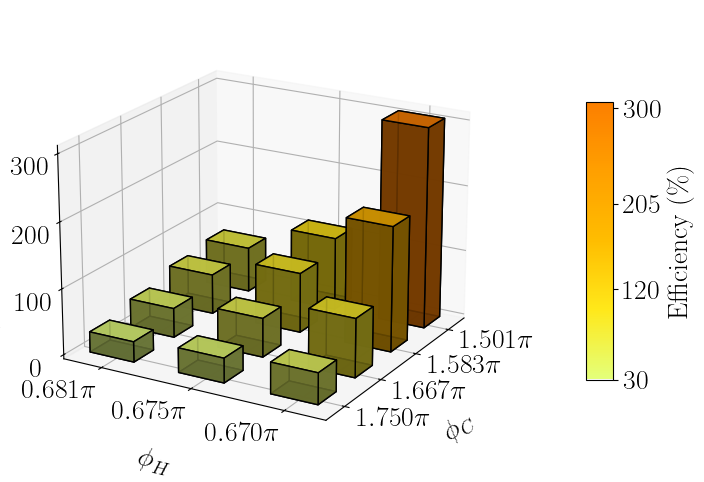

In [12]:

filtered_df = filter_df(df_simulations, 
                        [("cavity1", "compressing_force"), 2.0],
                        [("cavity2", "compressing_force"), 2.0],
                        [("stroke", "time_isochore"), 40000],
                        positive_efficiency=False,
                        )
excluded_cold_angles = [1/40, 1/8, 1/20, 1/50]
filtered_df = filtered_df[~filtered_df["phaseonium_phi_cold"].isin(excluded_cold_angles)]
filtered_df = filtered_df[filtered_df["phaseonium_phi_hot"] < 0.862]
pivot_table, names_table = make_pivot_table(filtered_df, "phaseonium_phi_hot", "phaseonium_phi_cold", f"gain")
# fig, _ = plot_efficiency_scores(pivot_table, 
#                        xlabel="Cold Phaseonium Phase (units of $\\pi$)",
#                        ylabel="Hot Phaseonium Phase (units of $\\pi$)")
fig, _ = plot_efficiency_scores_3d(pivot_table,
                       xlabel="$\\phi_C$",
                       ylabel="$\\phi_H$",
                       tex=True)

fig.savefig(ROOT.parent / "img/efficiency_scores_coherence.png", bbox_inches="tight")
fig.savefig(ROOT.parent / "img/efficiency_scores_coherence.pdf", bbox_inches="tight")
fig.savefig(ROOT.parent / "img/efficiency_scores_coherence.svg", bbox_inches="tight")

In [47]:
1/1.17

0.8547008547008548

In [48]:
print(pivot_table.columns)
np.diff(np.array(pivot_table.columns))

Index([0.001, 0.08333333333333333, 0.16666666666666666, 0.25], dtype='float64', name='phaseonium_phi_cold')


array([0.08233333, 0.08333333, 0.08333333])

In [49]:
1 / np.linspace(0.25, 0.001, 4)

array([   4.        ,    5.98802395,   11.9047619 , 1000.        ])

### Efficiency vs Thermalization Time

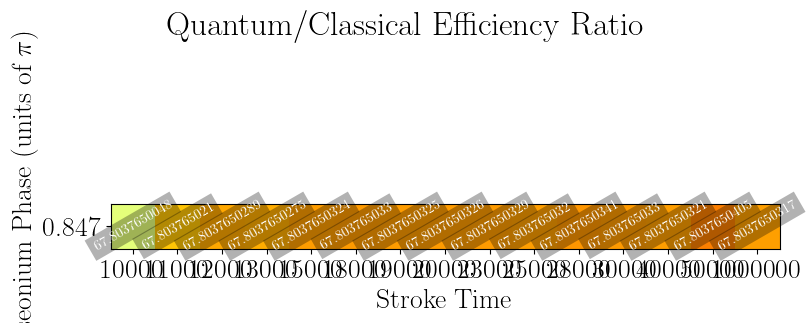

In [50]:
filtered_df = filter_df(df_simulations, 
                        [("cavity1", "compressing_force"), 2.0],
                        [("cavity2", "compressing_force"), 2.0],
                        [("phaseonium", "phi_hot"), 1.18],
                        [("phaseonium", "phi_cold"), 40.0],
                        )
pivot_table, names_table = make_pivot_table(filtered_df, "phaseonium_phi_hot", "stroke_time_isochore", f"gain")
fig, _ = plot_efficiency_scores(pivot_table, precision=10, xlabel="Stroke Time", ylabel="Hot Phaseonium Phase (units of $\\pi$)")

fig.savefig(ROOT.parent / "img/efficiency_scores_thermalization.png")
fig.savefig(ROOT.parent / "img/efficiency_scores_thermalization.pdf")

In [51]:
filtered_df[["meta_name", "stroke_time_isochore"]].sort_values(by="stroke_time_isochore")

,meta_name,stroke_time_isochore
20,26283a1e-8,10000
40,4ddc1207-c,11000
112,dad88422-0,12000
27,2f9c7e10-f,13000
2,050df8a8-2,15000
79,9b166bbe-b,15000
123,ec554e40-7,18000
66,7af1d124-d,19000
41,4f0d53ca-a,20000
3,081fec97-1,23000


In [52]:
def negativity_bipartite(rho, dim_A=15, dim_B=15):
    """
    Calculate negativity for a bipartite system.
    
    Parameters:
    rho: Qobj - density matrix of the bipartite system
    dim_A: int - dimension of subsystem A (default: 15)
    dim_B: int - dimension of subsystem B (default: 15)
    
    Returns:
    float - negativity value
    """
    # Ensure proper dimensions are set
    rho.dims = [[dim_A, dim_B], [dim_A, dim_B]]
    
    # Partial transpose with respect to subsystem A (first subsystem)
    rho_pt = qt.partial_transpose(rho, [0, 1])
    
    # Calculate eigenvalues of the partially transposed matrix
    eigenvals = rho_pt.eigenenergies()
    
    # Negativity is the sum of absolute values of negative eigenvalues
    negative_eigenvals = eigenvals[eigenvals < 1e-12]
    negativity = -np.sum(negative_eigenvals)
    
    return negativity

In [53]:
mutinfs = []
al_works1 = []
al_works2 = []
total_al_works = []
pr_works1 = []
pr_works2 = []
total_pr_works = []
heats = []
n_max = []
n_time = []
n_len = []
n_series = []

for i, simulation in enumerate(filtered_df["meta_name"]):
    f = ROOT / f"simulation_{simulation}"
    with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
        evolution_history = pickle.load(zipfile)


    timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
    ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)

    working_time1 = np.where([stroke_times[1][0] < s < stroke_times[1][1] for s in sampling_times])[0]
    working_time2 = np.where([stroke_times[-1][0] < s < stroke_times[-1][1] for s in sampling_times])[0]
    mutinf = np.array(evolution_history["S"]["Mutual Information"])
    mutinfs.append(np.sum(mutinf[working_time1]))

    al_work = np.array(evolution_history["S"]["Work"]["Alicki"])
    al_works1.append(-np.sum(al_work[working_time1]))
    al_works2.append(-np.sum(al_work[working_time2]))
    total_al_works.append(al_work.sum())
    
    pr_work1 = np.array(evolution_history["S1"]["Work"]["Pressure"])
    pr_work2 = np.array(evolution_history["S2"]["Work"]["Pressure"])
    pr_work = pr_work1 + pr_work2
    pr_works1.append(np.sum(pr_work[working_time1]))
    pr_works2.append(np.sum(pr_work[working_time2]))
    total_pr_works.append(pr_work.sum())

    heat = sum(q for q in evolution_history["S"]["Heat"] if q > 0)
    heats.append(np.array(heat))

    negativities = np.zeros(len(sampling_times))
    for j, s in enumerate(evolution_history["S"]["State"]):
        rho = Qobj(s, dims=[[ndims, ndims], [ndims, ndims]])
        neg = negativity_bipartite(rho, dim_A=ndims, dim_B=ndims)
        negativities[j] = neg

    n_series.append(negativities)
    n_max.append(negativities.max())
    n_time.append(negativities.argmax())
    n_len.append(np.sum(negativities > 0))

### Mutual Information

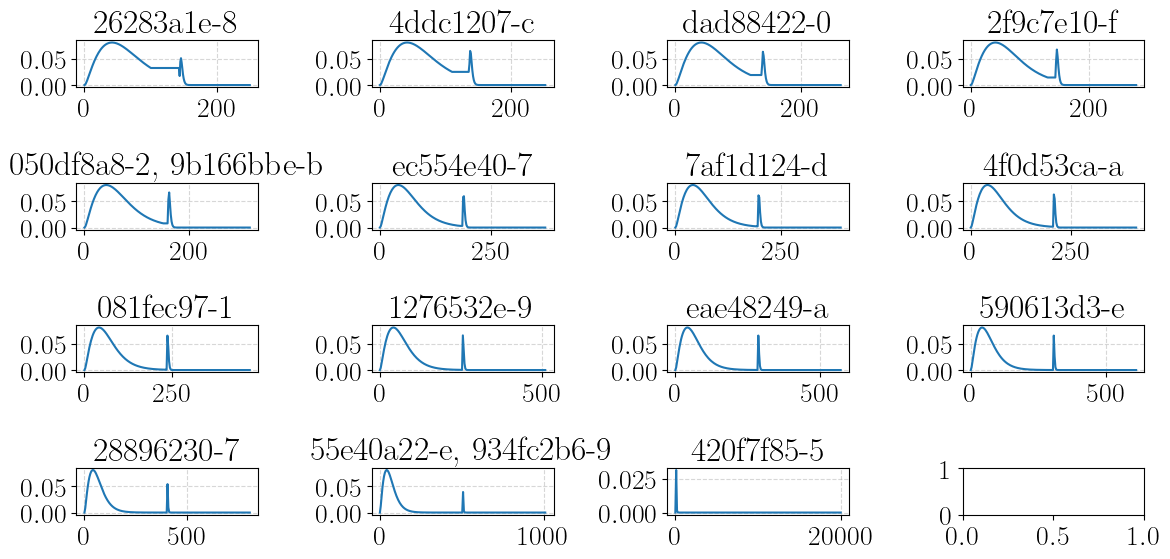

In [54]:
figures_layout = filtered_df.pivot_table(
    index="phaseonium_phi_hot", columns="stroke_time_isochore", values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
fig, axs = plt.subplots(4, 4, figsize=(12, 6), layout='tight')
axs = axs.flatten()
if isinstance(axs, np.ndarray):
    axs = axs.flatten()

mutinf_series = []
for i, row in enumerate(figures_layout.index):
    for j, col in enumerate(figures_layout.columns):
        filename = figures_layout.iloc[i, j].split(", ")[0].strip()
        f = ROOT / f"simulation_{filename}"
        if not f.exists():
            print(f"Cannot open {f}")
            continue

        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            mutinf = pickle.load(zipfile)["S"]["Mutual Information"]
        timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        mutinf_series.append(np.array(mutinf))
        ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)
        current_ax = i * len(figures_layout.columns) + j
        plot_observable(sampling_times, mutinf, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)


### Works

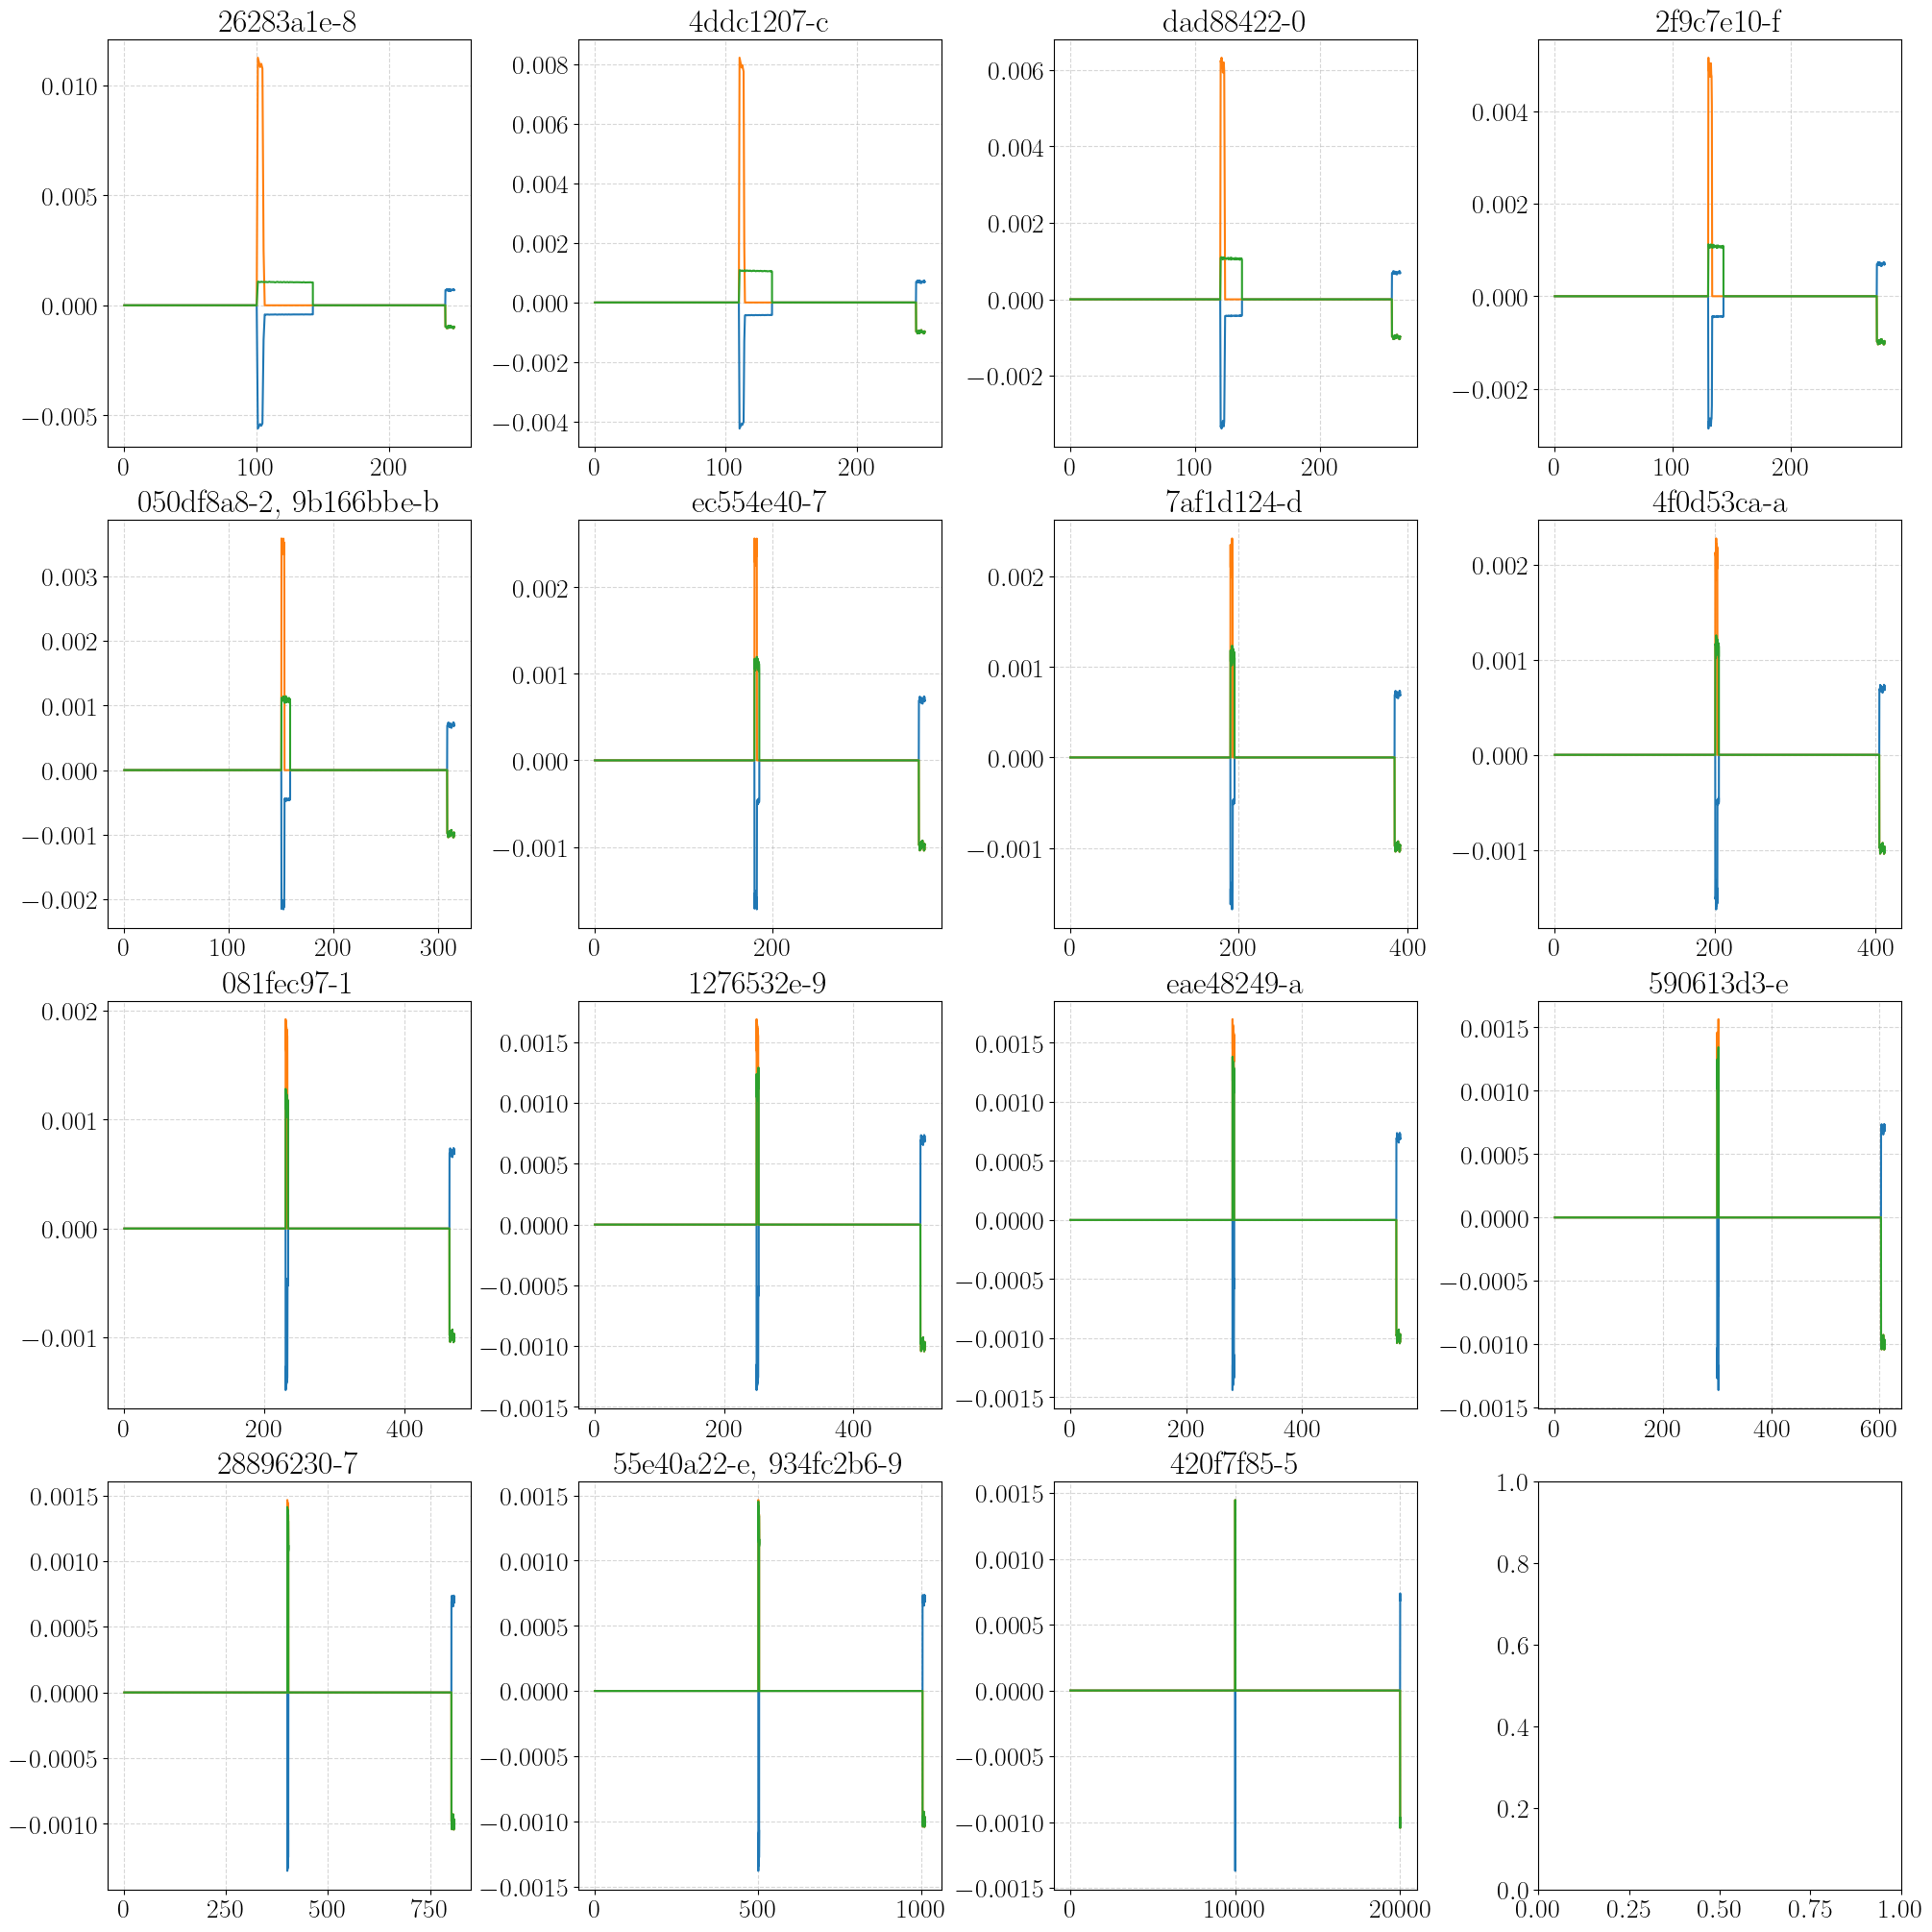

In [55]:
figures_layout = filtered_df.pivot_table(
    index="phaseonium_phi_hot", columns="stroke_time_isochore", values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
fig, axs = plt.subplots(4, 4, figsize=(20, 20), layout='constrained')
axs = axs.flatten()
if isinstance(axs, np.ndarray):
    axs = axs.flatten()

for i, row in enumerate(figures_layout.index):
    for j, col in enumerate(figures_layout.columns):
        filename = figures_layout.iloc[i, j].split(", ")[0].strip()
        f = ROOT / f"simulation_{filename}"
        if not f.exists():
            print(f"Cannot open {f}")
            continue

        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            evolution_history = pickle.load(zipfile)
        timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        
        alicki_work = np.array(evolution_history["S"]["Work"]["Alicki"])
        alicki_work1 = np.array(evolution_history["S1"]["Work"]["Alicki"])
        alicki_work2 = np.array(evolution_history["S2"]["Work"]["Alicki"])
        
        pressure_work1 = evolution_history["S1"]["Work"]["Pressure"]
        pressure_work1[0] = 0
        pressure_work1 = np.array(pressure_work1)
        pressure_work2 = evolution_history["S2"]["Work"]["Pressure"]
        pressure_work2[0] = 0
        pressure_work2 = np.array(pressure_work2)
        
        classic_work = np.array(evolution_history["S"]["Work"]["Classic"])
        classic_work1 = np.array(evolution_history["S1"]["Work"]["Classic"])
        classic_work2 = np.array(evolution_history["S2"]["Work"]["Classic"])
        
        ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)
        current_ax = i * len(figures_layout.columns) + j
        plot_observable(sampling_times, alicki_work, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        plot_observable(sampling_times, pressure_work1, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        # plot_observable(sampling_times, classic_work1, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        plot_observable(sampling_times, pressure_work2, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)
        # plot_observable(sampling_times, classic_work2, stroke_times, ax=axs[current_ax], title=figures_layout.iloc[i, j], grid=True)


### One Cycle

In [56]:
# al_works = []
# pr_works = []
# qu_works = []
# files = []
# for i, row in enumerate(figures_layout.index):
#     for j, col in enumerate(figures_layout.columns):
#         filename = figures_layout.iloc[i, j].split(", ")[0].strip()
#         files.append(filename)
#         f = ROOT / f"simulation_{filename}"
#         if not f.exists():
#             print(f"Cannot open {f}")
#             continue

#         with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
#             evolution_history = pickle.load(zipfile)
#         timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        
#         alicki_work = np.array(evolution_history["S"]["Work"]["Alicki"])
#         alicki_work1 = np.array(evolution_history["S1"]["Work"]["Alicki"])
#         alicki_work2 = np.array(evolution_history["S2"]["Work"]["Alicki"])
        
#         pressure_work1 = evolution_history["S1"]["Work"]["Pressure"]
#         pressure_work1[0] = 0
#         pressure_work1 = np.array(pressure_work1)
#         pressure_work2 = evolution_history["S2"]["Work"]["Pressure"]
#         pressure_work2[0] = 0
#         pressure_work2 = np.array(pressure_work2)
        
#         classic_work = np.array(evolution_history["S"]["Work"]["Classic"])
#         classic_work1 = np.array(evolution_history["S1"]["Work"]["Classic"])
#         classic_work2 = np.array(evolution_history["S2"]["Work"]["Classic"])
        
#         pressure_work_total = pressure_work1 + pressure_work2
#         quantum_work = alicki_work - (alicki_work1 + alicki_work2)
#         al_works.append(alicki_work)
#         pr_works.append(pressure_work_total)
#         qu_works.append(quantum_work)
#         # Create figure
#         fig = plt.figure(figsize=(14, 10))
#         # fig, ax = plt.subplots(figsize=(14, 11), layout='tight')
#         fig.suptitle(f"Work Dynamics in the Cycle {figures_layout.iloc[i, j]}")
#         # Top left subplot
#         ax1 = plt.subplot2grid((2, 2), (0, 0))
#         # Top right subplot
#         ax2 = plt.subplot2grid((2, 2), (0, 1))
#         # Bottom subplot (spans both columns)
#         ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

#         plot_observable(sampling_times, -alicki_work1, stroke_times, ax=ax1, label="Alicki", grid=True)
#         plot_observable(sampling_times, pressure_work1, stroke_times, ax=ax1, label="Pressure", grid=True)
#         plot_observable(sampling_times, classic_work1, stroke_times, ax=ax1, label="Classic", grid=True)

#         plot_observable(sampling_times, -alicki_work2, stroke_times, ax=ax2, label="Alicki", grid=True)
#         plot_observable(sampling_times, pressure_work2, stroke_times, ax=ax2, label="Pressure", grid=True)
#         plot_observable(sampling_times, classic_work2, stroke_times, ax=ax2, label="Classic", grid=True)

#         plot_observable(sampling_times, -alicki_work, stroke_times, ax=ax3, label="Alicki's Work", grid=True)
#         plot_observable(sampling_times, pressure_work_total, stroke_times, ax=ax3, label="Pressure", grid=True)
#         plot_observable(sampling_times, classic_work1 + classic_work2, stroke_times, ax=ax3, label="Classic", grid=True)
#         plot_observable(sampling_times, -alicki_work1 - alicki_work2, stroke_times, ax=ax3, label="Alicki1 + Alicki2", grid=True)
#         plot_observable(sampling_times,-quantum_work, stroke_times, ax=ax3, label="Quantum Work", grid=True)

#         working_time = np.where([stroke_times[1][0] < s < stroke_times[1][1] for s in sampling_times])[0]
#         quantum_discrepancy = -quantum_work[working_time] - pressure_work_total[working_time]
    
#         print(f"Average Alicki's discrepancy for S1: {np.mean(-alicki_work1[working_time] - pressure_work1[working_time])}")
#         print(f"Average Alicki's discrepancy for S2: {np.mean(-alicki_work2[working_time] - pressure_work2[working_time])}")
#         print(f"Average Quantum Work: {np.mean(quantum_work)}")
#         print(f"Average Quantum Work 1: {np.mean(quantum_work)}")
#         print(f"Average Alicki's discrepancy for S: {np.mean(-alicki_work[working_time] - pressure_work1[working_time] - pressure_work2[working_time])}")
#         print("___________________")
#         ax1.set_title(f"Average Alicki's discrepancy in S1: {np.mean(-alicki_work1[working_time] - pressure_work1[working_time]):.6f}")
#         ax2.set_title(f"Average Alicki's discrepancy in S2: {np.mean(-alicki_work2[working_time] - pressure_work2[working_time]):.6f}")
#         # ax.set_ylim(-0.005, 0.035)
#         # ax.set_xlim(stroke_times[1][0] - 100, stroke_times[1][1] + 100)
#         # ax.text(stroke_times[1][0], -0.005, f"Average Alicki's discrepancy: {np.mean(-alicki_work[working_time] - pressure_work1[working_time] - pressure_work2[working_time]):.6f}")
#         # ax.text(stroke_times[1][0], -0.01, f"Average Quantum discrepancy: {np.mean(quantum_discrepancy)/np.mean(pressure_work_total[working_time]):.6f}")
#         # plot_observable(sampling_times, classic_work2, stroke_times, ax=axs[1, 0], label="Classic", grid=True)

#         fig.savefig(f / "visualization/work_dynamics.png", bbox_inches='tight')
#         fig.savefig(f / "visualization/work_dynamics.pdf", bbox_inches='tight')

In [57]:
# plt.rcParams.update({'text.usetex': True, 'font.family': 'serif', 'font.size': 21})
# num = len(al_works1)
# fig, axs = plt.subplots(num, 1, figsize=(8, 12), layout='tight')
# axs = axs.flatten()

# slopes_xs = []
# slopes_ys = []

# for i in range(num):
#     ax = axs[i]
#     ax.plot(sampling_times, -al_works1[i], label=r"$W_{Al}$")
#     ax.plot(sampling_times, pr_works1[i], label="$W_m$")
#     # ax.plot(sampling_times, -qu_works[i], label="$W_Q$")

#     mutinf_adiabatic = mutinfs[i][working_time]
#     avg_mutinf = np.abs(mutinf_adiabatic.sum())
#     avg_presswork = np.abs(pr_works[i][working_time].sum())
#     avg_alicki = np.abs(al_works[i][working_time].sum())
#     avg_quwork = np.abs(qu_works[i][working_time].sum())
#     quwork_ratio = avg_quwork / avg_alicki
#     works_ratio = avg_presswork / avg_alicki
#     works_diff = avg_presswork - avg_alicki
#     ax.set_title(f"Mutual Information = ${avg_mutinf:.3f}$, $W^m = {avg_presswork:.3g}$, $W^{{Al}} = {works_ratio:.4g}$",
#                   loc='left', size=20)

#     plot_stroke_overlays(ax, -0.001, 0.014, stroke_times)

#     ax.set_xlim(stroke_times[1][0] - 200, stroke_times[1][1] + 200)
#     ax.set_yticks(np.arange(0.00, 0.015, 0.007))
#     ax.set_ylim(-0.001, 0.014)

#     slopes_xs.append(np.abs(mutinf_adiabatic.sum()))
#     slopes_ys.append([
#         np.abs(pr_works[i][working_time].sum()),
#         np.abs(al_works[i][working_time].sum()),
        
#         ])
    
#     if i == 0:
#         fig.legend(bbox_to_anchor=(0., 1., 1.04, 0.06), loc=2, ncol=2, mode="expand", prop={'size': 20})


# # fig.savefig(ROOT.parent / "img/different_works.png", bbox_inches="tight", dpi=300)
# # fig.savefig(ROOT.parent / "img/different_works.pdf", bbox_inches="tight", dpi=300)

In [58]:
thermodf = pd.DataFrame(np.array([mutinfs, al_works1, al_works2, total_al_works, pr_works1, pr_works2, total_pr_works, heats, n_max, n_len, n_time]).T, 
             columns=["Mutinf", "Al Expanding", "Al Compressing", "Total Al", "Pr Expanding", "Pr Compressing", "Total Pr", "Heats", "Negativity Max", "Negativity Len", "Negativity Time"]
             )
thermodf.sort_values(by="Mutinf", inplace=True)
thermodf.to_csv(ROOT / "thermodynamic_values.csv")

In [59]:
a = 10
b = 5
a1 = a /2 
b1 = b /2
print(a - b)
print(a1- b1)

5
2.5


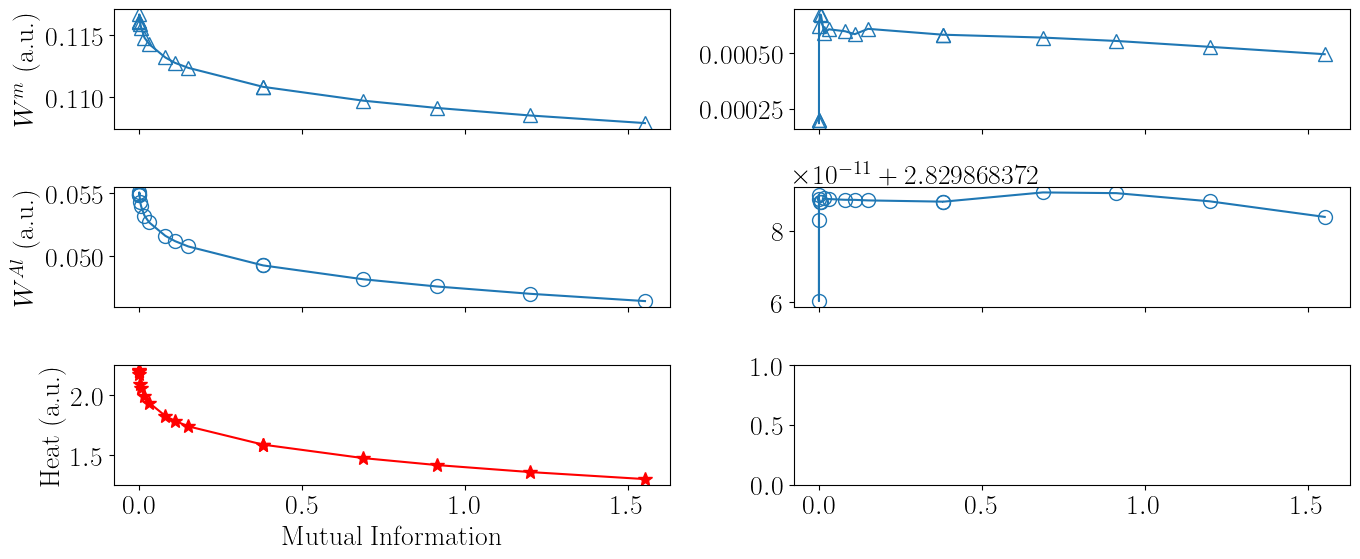

In [60]:
df = df_simulations.set_index(("meta", "name"))
fig, axs = plt.subplots(3, 2, figsize=(14, 6), layout='tight', sharex=True)

axs[0, 0].plot(thermodf["Mutinf"], thermodf["Pr Expanding"], '-^', markersize=10, markerfacecolor='none', label="Classical Work")
axs[1, 0].plot(thermodf["Mutinf"], thermodf["Al Expanding"], '-o', markersize=10, markerfacecolor='none', label="Quantum Work")
axs[2, 0].plot(thermodf["Mutinf"], thermodf["Heats"], '-*', markersize=10, label="Heat", color='red')
axs[-1, 0].set_xlabel("Mutual Information", fontsize=20)
axs[0, 0].set_ylabel("$W^m$ (a.u.)", fontsize=20)
axs[1, 0].set_ylabel("$W^{Al}$ (a.u.)", fontsize=20)
axs[2, 0].set_ylabel("Heat (a.u.)", fontsize=20)

axs[0, 1].plot(thermodf["Mutinf"], thermodf["Pr Expanding"] + thermodf["Pr Compressing"] - thermodf["Al Expanding"] - thermodf["Al Compressing"], '-^', markersize=10, markerfacecolor='none', label="Classical Work")
axs[1, 1].plot(thermodf["Mutinf"], thermodf["Pr Compressing"] / thermodf["Al Compressing"], '-o', markersize=10, markerfacecolor='none', label="Quantum Work")
# axs[-1, 1].set_xlabel("Mutual Information", fontsize=20)
# axs[0, 1].set_ylabel("$W^m$ (a.u.)", fontsize=20)
# axs[1, 1].set_ylabel("$W^{Al}$ (a.u.)", fontsize=20)
# axs[2, 1].set_ylabel("Heat (a.u.)", fontsize=20)

# fig.savefig(ROOT.parent / "img/energy_vs_mutualinfo.png", bbox_inches="tight", dpi=300)
# fig.savefig(ROOT.parent / "img/energy_vs_mutualinfo.pdf", bbox_inches="tight", dpi=300)

In [61]:
from matplotlib.gridspec import GridSpec

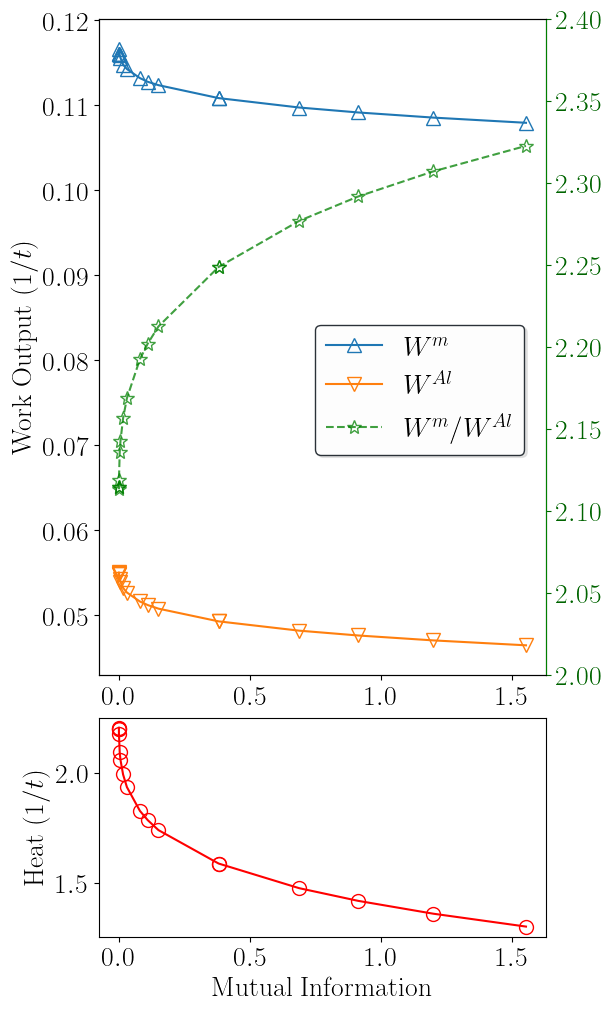

In [62]:
fig = plt.figure(layout="constrained", figsize=(6, 10))
gs = GridSpec(4, 1, figure=fig)

ax1 = fig.add_subplot(gs[:-1])
# ax1.set_xlabel("Mutual Information", fontsize=20)
ax1.set_ylabel("Work Output $(1/t)$", fontsize=20)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[-1])
ax3.set_ylabel("Heat $(1/t)$", fontsize=20)
ax3.set_xlabel("Mutual Information", fontsize=20)

wcl, = ax1.plot(thermodf["Mutinf"], thermodf["Pr Expanding"], '-^', markersize=10, markerfacecolor='none', label="Classical Work")
wq, = ax1.plot(thermodf["Mutinf"], thermodf["Al Expanding"], '-v', markersize=10, markerfacecolor='none', label="Quantum Work")
ht = ax3.plot(thermodf["Mutinf"], thermodf["Heats"], '-o', markersize=10, markerfacecolor='none', label="$Q$", color='red')

wr, = ax2.plot(thermodf["Mutinf"], thermodf["Pr Expanding"] / thermodf["Al Expanding"], '--*', 
               color='green', markerfacecolor='none', markersize=10, alpha=0.75)
ax2.set_ylim(2.0, 2.4)
ax2.spines['right'].set_color('green')
ax2.tick_params(axis='y', color='darkgreen', labelcolor='darkgreen')

legend = fig.legend(
    [wcl, wq, wr], 
    ["$W^{m}$", "$W^{Al}$", "$W^{m}/W^{Al}$"], 
    loc=((0.515, 0.55)), 
    
    # Advanced visual effects
    frameon=True,
    fancybox=True,
    shadow={
        'color': '#cccccc',      # Shadow color
        'antialiased': True,
    },
    framealpha=0.95,
    facecolor='#ffffff',
    edgecolor="#1F262D",
)

fig.savefig(ROOT.parent / "img/energy_vs_mutualinfo.png", bbox_inches="tight", dpi=300)
fig.savefig(ROOT.parent / "img/energy_vs_mutualinfo.pdf", bbox_inches="tight", dpi=300)

In [63]:
1/40 + 1.5

1.525

In [64]:
thermodf["Pr Total"] = thermodf["Pr Expanding"] + thermodf["Pr Compressing"]
thermodf["Al Total"] = thermodf["Al Expanding"] + thermodf["Al Compressing"]
thermodf["Diff"] = thermodf["Pr Total"] + thermodf["Al Total"]
thermodf["Ratio Expanding"] = thermodf["Pr Expanding"] / thermodf["Al Expanding"]
thermodf["Ratio Compressing"] = thermodf["Pr Compressing"] / thermodf["Al Compressing"]
thermodf[["Pr Expanding", "Al Expanding", "Pr Compressing", "Al Compressing", "Pr Total", "Al Total", "Diff", "Ratio Expanding", "Ratio Compressing"]]

,Pr Expanding,Al Expanding,Pr Compressing,Al Compressing,Pr Total,Al Total,Diff,Ratio Expanding,Ratio Compressing
6,0.116086,0.054930,-0.09429,-0.03332,0.021796,0.021610,0.043407,2.113354,2.829868
12,0.116057,0.054885,-0.09429,-0.03332,0.021767,0.021566,0.043333,2.114536,2.829868
9,0.116057,0.054885,-0.09429,-0.03332,0.021767,0.021566,0.043333,2.114536,2.829868
4,0.116645,0.055054,-0.09429,-0.03332,0.022355,0.021734,0.044089,2.118760,2.829868
10,0.115918,0.054274,-0.09429,-0.03332,0.021628,0.020955,0.042583,2.135789,2.829868
15,0.115587,0.053945,-0.09429,-0.03332,0.021297,0.020626,0.041923,2.142677,2.829868
2,0.114788,0.053227,-0.09429,-0.03332,0.020498,0.019908,0.040405,2.156556,2.829868
1,0.114261,0.052684,-0.09429,-0.03332,0.019971,0.019364,0.039335,2.168811,2.829868
8,0.113194,0.051626,-0.09429,-0.03332,0.018904,0.018306,0.037210,2.192592,2.829868
11,0.112761,0.051206,-0.09429,-0.03332,0.018471,0.017886,0.036358,2.202119,2.829868


In [65]:
thermodf["Al Expanding"]

6     0.054930
12    0.054885
9     0.054885
4     0.055054
10    0.054274
15    0.053945
2     0.053227
1     0.052684
8     0.051626
11    0.051206
16    0.050785
0     0.049289
13    0.049289
5     0.048196
14    0.047628
7     0.047050
3     0.046472
Name: Al Expanding, dtype: float64

## Entanglement

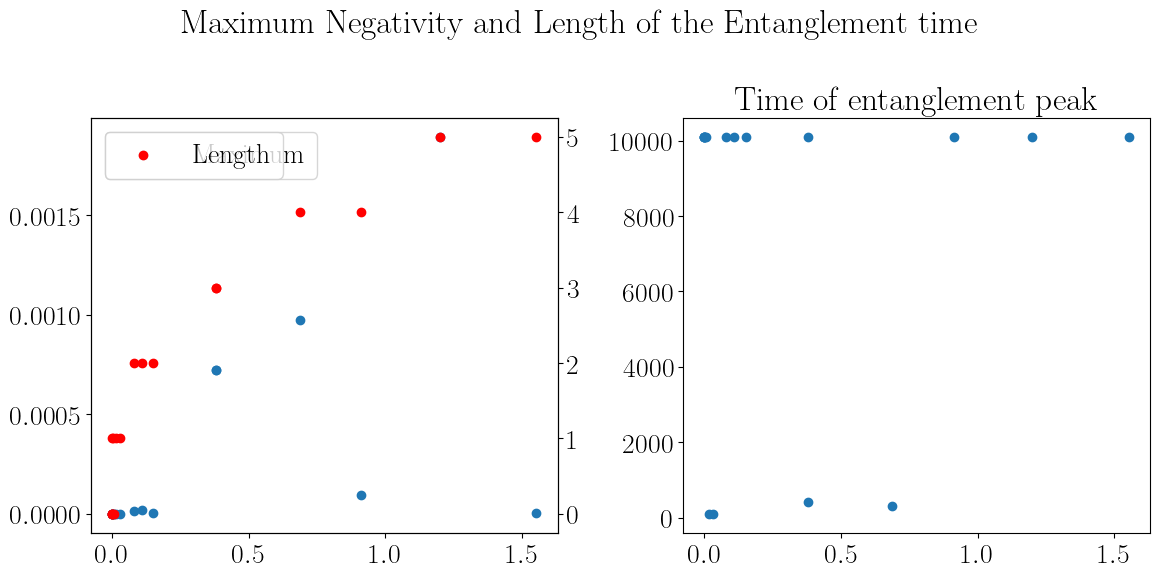

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='tight')
fig.suptitle("Maximum Negativity and Length of the Entanglement time")
axs[0].scatter(thermodf["Mutinf"], thermodf["Negativity Max"], label="Maximum")
ax2 = axs[0].twinx()
ax2.scatter(thermodf["Mutinf"], thermodf["Negativity Len"], color="red", label="Length")
axs[1].scatter(mutinfs, [sampling_times[int(i)] for i in thermodf["Negativity Time"]])
axs[1].set_title("Time of entanglement peak")
axs[0].legend()
ax2.legend()

151


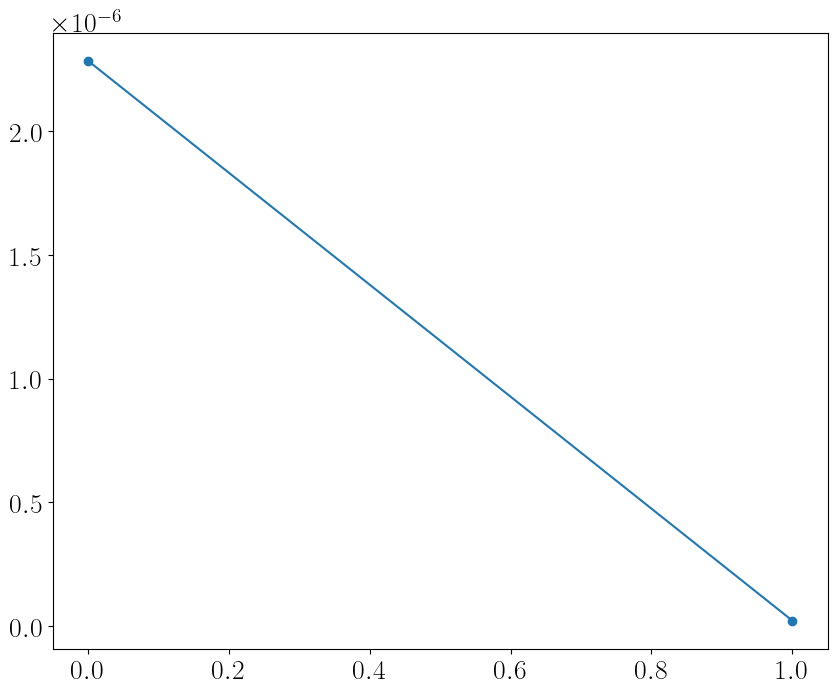

In [67]:
print(negativities.argmax())
fig, axs = plt.subplots(figsize=(10, 8))
axs.plot(negativities[negativities > 0], "-o")
# plot_stroke_overlays(axs, -0.001, 0.002, stroke_times=stroke_times)